# Climate change and multilateral migration

This code: *Hendrik Scheewel* (hendrik.scheewel@uliege.be)

Joint project with: *Frédéric Docquier*, *Michał Burzyński*

Todo:
- [ ] Compare population levels by country
- [ ] Compare fractions of people in cities by country
- [ ] Compare internal and international migration

# Load packages

In [4]:
# import packages
import pandas as pd
import numpy as np
import math
import datetime
import pycountry
from numba import jit, vectorize, float64, guvectorize, njit
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
sns.set_palette('Paired')
import itertools
from scipy.optimize import minimize
import statsmodels.formula.api as sm
colors = sns.color_palette()

In [5]:
R = ('a', 'n')                      # regions
S = ('l', 'h')                      # skills
BB = ('d', 'f')                     # areas
T = (1980, 2010, 2040, 2070, 2100)  # periods of interest
t0 = 1950                           # first period

# Simulation class

In [6]:
class model:
    def __init__(self,
                 name, # name of the model instance
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 B=0.5, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='inputs.xlsx', # input of data
                 scenario='intermediate',
                 south_south_mig = True): # climate change scenario
        
        self.σ, self.τ, self.μ, self.B, self.tol  = σ, τ, μ, B, tol
        
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')  
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')  
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        # irsbt = origin-destination-region-skill-time-specific
        data_ijrst = get_input(inputs, 'ijrsbt') 
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.Y = data_irt['Y'] # GDP
        self.ω = data_irt['ω'] # 
        self.Γ__n = data_irt['Γ__n'] # high-to-low-skill fertility ratio
        self.Γ__w = data_irt['Γ__w'] # high-to-low-skill wage ratio
        self.L = data_irst['L'] # resident population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.Mij = data_ijrst['Mij'] # number of emigrants
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        
        if south_south_mig == False:
            t = 2010
            for r in R:
                for s in S:
                    self.Mij[(r,s,'d',t)] = self.Mij[(r,s,'d',t)].multiply(self.OECD,1)

In [7]:
def correct_south_south(self):
    for s in S:
        self.L[('n',s,2010)] = self.L[('n',s,2010)] + (self.Mij[('a',s,'d',2010)] + self.Mij[('n',s,'d',2010)]).multiply(1-self.OECD,1).sum()
        
model.correct_south_south = correct_south_south

In [8]:
def MidxDataFrame(self,dim,value=np.nan):
    """ Creates multi-indexed empty dataframe with country-index"""
    return(pd.DataFrame(value, index=self.countries,
                        columns=pd.MultiIndex.from_product(dim)))

model.MidxDataFrame = MidxDataFrame

## Calibration methods

### Calibration of skill-biased externality κ

In [9]:
def calib_kappa(self):
    self.κ = {'a': 0.0, 'n': np.nan}
    self.Γ__η_bar = {'a': 1.32558139534884, 'n': np.nan}
    self.Γ__L = self.MidxDataFrame([R, [2010]])
    self.Γ__η = self.MidxDataFrame([['n'], [2010]])

    def Γ__L(r, t):
        return(self.L[(r,'h',t)]/self.L[(r,'l',t)])
    
    def Γ__η_cal(r, t):
        if r == 'n':
            return(self.Γ__w[(r,t)] * self.Γ__L[(r,t)]**(1/self.σ[r]))
        else:
            return(self.Γ__η_bar[r])
    
    for t in [1980,2010]:
        for r in R:
            self.Γ__L[(r,t)] = Γ__L(r, t)
            self.Γ__η[(r,t)] = Γ__η_cal(r, t)

    t = 2010
    df = pd.DataFrame({'Γ__η': self.Γ__η[('n',t)],'Γ__L': self.Γ__L[('n',t)]})

    reg = sm.ols(formula="np.log(Γ__η) ~ np.log(Γ__L)", data=df).fit()

    self.κ['n'] = 0.5*reg.params['np.log(Γ__L)']

    self.Γ__η_bar['n'] = np.exp(reg.params['Intercept'])

model.calib_kappa = calib_kappa

### Calibration of Total factor productivity A

In [10]:
def calib_A(self):
    σ = self.σ
    
    self.η = self.MidxDataFrame([R, S, [min(T)]])
    self.A = self.MidxDataFrame([R, [min(T)]])
    
    def η_cal(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)
        
    def A_cal(r, t):
        ''' TFP '''
        if r == 'a':
            return((self.Y[(r, t)]) /
                  (self.η[(r,'l',t)] * self.L[(r,'l',t)] +
                   self.η[(r,'h',t)] * self.L[(r,'l',t)]))
        else:
            return(self.Y[(r, t)] /
                 (self.η[(r,'l',t)] * (self.L[(r,'l',t)])**((σ[r]-1)/σ[r]) +
                  self.η[(r,'h',t)] * (self.L[(r,'l',t)])**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
    
    for t in [1980,2010]:
        for r in R:
            for s in S:
                self.η[(r, s, t)] = η_cal(r, s, t)
        
    for t in [1980,2010]:
        for r in R:
            self.A[(r,t)] = A_cal(r, t)

model.calib_A = calib_A

### Calibration of aggregate externality ε

In [11]:
def calib_epsilon(self):
    self.ε = {'a': np.nan, 'n': np.nan} # aggregate externality
    self.Γ__L = self.MidxDataFrame([R, [1980,2010]]) # high-to-low-skill resid. pop. ratio
    self.A_bar = pd.DataFrame(index=self.countries) # scale factor in TFP

    t = 1980
    for r in R:
        self.D[(r, t)] = self.D[(r, t+30)]
    for r in R:
        for t in [1980,2010]:
            self.Γ__L[(r,t)] = self.L[r,'h',t]/self.L[r,'l',t]
        
    df = pd.concat([self.A,self.Γ__L],1,keys=['A','Γ__L'])

    def reg(r):
        df = self.A[r].melt(var_name='year1980',value_name='A')
        df = df.join(self.Γ__L[r].melt(var_name='year1980'
                                       ,value_name='Γ__L')['Γ__L'])
        df.year1980 = np.where(df.year1980 == 1980,1,0)
        
        reg = sm.ols(formula="np.log(A) ~ np.log(Γ__L) + year1980", 
                     data=df).fit()

        return(reg.params)

    self.γ = reg('a')['year1980'] ** (1/30)
    self.γ = 1.00256317290118    

    t = 1980
    for r in R:
        self.ε[r] = 0.5 * reg(r)['np.log(Γ__L)']
        self.A_bar[r] = self.A[(r,t)]/(self.γ * self.Γ__L[(r,t)]**self.ε[r] * self.D[(r,t)])
    
model.calib_epsilon = calib_epsilon

### Calibration of migration costs

In [12]:
def calib_migcosts(self):
    σ, μ, B = self.σ, self.μ, self.B
    τ, ε, κ, Γ__η_bar = self.τ, self.ε, self.κ, self.Γ__η_bar
    tol = self.tol
    γ = self.γ
    
    t = 2010
    
    # Create empty dataframes for emigrant to stayer ratios, stayers and migrants
    self.N = self.MidxDataFrame([R, S, [t]])
    self.miF = self.MidxDataFrame([R, S, [t]])
    self.Ms = self.MidxDataFrame([R, S, BB, [t]])
    self.Mii = self.MidxDataFrame([R, S, BB, [t]])
    self.MiF = self.MidxDataFrame([R, S, [t]])

    for s in S:
        N_s_hat     = (self.L[('a',s,t)] + self.L[('n',s,t)] 
                                 + (self.Mij[('a',s,'d',2010)] + self.Mij[('n',s,'d',2010)]).sum(1) 
                                 - (self.Mij[('a',s,'d',2010)] + self.Mij[('n',s,'d',2010)]).sum(0))
        L_a_s_hat   = self.L[('a',s,2010)]
        L_n_s_hat   = self.L[('n',s,2010)]
        M_aF_s_hat  = self.Mij[('a',s,'d',2010)].sum(1)
        M_nF_s_hat  = self.Mij[('n',s,'d',2010)].sum(1)
        I_s_hat     = (self.Mij[('a',s,'d',2010)] + self.Mij[('n',s,'d',2010)]).sum(0)
        m_an_s      = self.mii[('a',s,'d',2010)]
        v_n_s       = 1

        # for all countries: internal emigrant-to-stayer ratios of high-skilled = 0.3
        if s == 'h':
            m_an_s = pd.Series(0.3,index=self.countries)
        # problematic observations: set internal emigrant to stayer ratio = 0
        if s == 'l':
            m_an_s.loc['Tonga'] = 0

        m_aF_s = M_aF_s_hat/(L_a_s_hat - (1-v_n_s)*I_s_hat)
        m_nF_s = M_nF_s_hat/(L_n_s_hat - m_an_s * (L_a_s_hat - (1-v_n_s)*I_s_hat) - v_n_s * I_s_hat)
        N_a_s = (L_a_s_hat - (1-v_n_s)*I_s_hat) * (1+m_an_s+m_aF_s)
        N_n_s = (L_n_s_hat - m_an_s * (L_a_s_hat - (1-v_n_s)*I_s_hat) - v_n_s * I_s_hat) * (1 + m_nF_s)
        M_aa_s = N_a_s/(1 + m_an_s + m_aF_s)
        M_nn_s = N_n_s/(1 + m_nF_s)
        M_an_s = m_an_s * M_aa_s
        M_aF_s = m_aF_s * M_aa_s
        M_nF_s = m_nF_s * M_nn_s
        RES_a = abs(N_a_s - (M_aa_s+M_aF_s+M_an_s))
        RES_n = abs(N_n_s - (M_nn_s+M_nF_s))

        self.mii[('a',s,'d',t)]  = m_an_s
        self.mii[('n',s,'d',t)]  = 0
        self.miF[('a',s,t)]  = m_aF_s
        self.miF[('n',s,t)]  = m_nF_s
        self.N[('a',s,t)]    = N_a_s
        self.N[('n',s,t)]    = N_n_s
        self.Ms[('a',s,'d', t)]   = M_aa_s
        self.Ms[('n',s,'d', t)]   = M_nn_s
        self.Mii[('a',s,'d', t)]  = M_an_s
        self.Mii[('n',s,'d', t)]  = 0
        self.MiF[('a',s,t)]  = M_aF_s
        self.MiF[('n',s,t)]  = M_nF_s
        
    self.mij = self.MidxDataFrame([R, S, [t], list(self.countries)])
    
    for r in R:
        for s in S:
            self.mij.loc[:,(r,s)] = np.array(self.Mij[(r,s,'d',t)].multiply((1/self.Ms[(r,s,'d',t)]),0))
            
    
    self.Γ__L = self.MidxDataFrame([R, [t]])
    self.η = self.MidxDataFrame([R, S, [t]])
    self.Γ__η = self.MidxDataFrame([R, [t]])
    self.Γ__w = self.MidxDataFrame([R, [t]])
    self.Y = self.MidxDataFrame([R, [t]])
    self.w = self.MidxDataFrame([R, S, [t]])
    self.c = self.MidxDataFrame([R, S, BB, [t]])
    self.v = self.MidxDataFrame([R, S, BB, T])
    self.xii = self.MidxDataFrame([R, S])
    self.xij = self.MidxDataFrame([R, S, list(self.countries)])


    ''' Functions '''
    # Before we can pin down bilateral migration costs
    # we need to identify indirect utilities:

    def Γ__L_cal(r, t):
        ''' Skill ratio in the labor force '''
        return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

    def Γ__η_cal(r, t):
        ''' Skill bias in relative productivity '''
        return (Γ__η_bar[r] * self.Γ__L[(r, t)]**κ[r])

    def η_cal(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)

    def A_cal(r, t):
        ''' Total factor productivity '''
        return (γ**(t - t0) * self.D[(r, t)]
                * self.A_bar[r] * self.Γ__L[(r, t)]**ε[r])

    def Y_cal(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)] 
                   * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((σ[r]-1)/σ[r])
                      + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

    def w_cal(r, s, t):
        ''' Wage rate '''
        if r == 'a':
            return (η_cal(r, s, t) * self.A[(r, t)])
        if r == 'n':
            return (η_cal(r, s, t) * self.A[(r, t)] ** ((σ[r]-1)/σ[r]) 
                    * (Y_cal(r, t) / self.L[(r, s, t)])**(1 / σ[r]))

    def Γ__w_cal(r, t):
        ''' High-low-skilled wage ratio '''
        return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

    def c_cal(r, s, b, t):
        ''' Consumption '''
        B = self.B
        if b == 'd':
            B = 0
        return((1-B) * self.w[(r, s, t)] )

    
    def v_cal(r, s, b, t):
        ''' Inner utility '''
        return((1 - τ[r]) * self.c[(r, s, b, t)])
    
    
    def xii_cal(r, s):
        ''' internal migration cost'''
        return(1 - self.mii[(r,s,b,t)]**μ * (self.v[(r,s,'d',t)]/self.v[('n',s,'d',t)]))
    
    def xij_cal(r, s):
        '''international migration cost'''
        vorig_over_vdest = np.outer(self.v[(r,s,'d',2010)],1/self.v[('n',s,'d',2010)])\
                            *(1-np.diag(np.ones(len(self.countries))))
        return(1 - self.mij[(r,s,t)]**self.μ
               * pd.DataFrame(vorig_over_vdest,index=self.countries,columns=self.countries))
    
    b = 'd'
    for t in [1980,2010]:
        for r in R:
            self.D[(r, t)] = self.D[(r, t+30)]
            self.Γ__L[(r, t)] = Γ__L_cal(r, t)
            self.Γ__η[(r, t)] = Γ__η_cal(r, t)
        for r in R:
            for s in S:
                self.η[(r, s, t)] = η_cal(r, s, t)
            self.Y[(r, t)] = Y_cal(r, t)
        for r in R:
            for s in S:
                self.w[(r, s, t)] = w_cal(r, s, t)
        for r in R:
            self.Γ__w[(r, t)] = Γ__w_cal(r, t)
        for r in R:
            for s in S:
                self.c[(r, s, b, t)] = c_cal(r, s, b, t)
        for r in R:
            for s in S:
                self.v[(r, s, b, t)] = v_cal(r, s, b, t)
    t = 2010
    for r in R:
        for s in S:
            self.xii[(r, s)] = xii_cal(r,s)
            self.xij.loc[:,(r,s)] = np.array(xij_cal(r,s))
            
    # Makes sure that we have no xii or xij < 0 (needs to be checked why this occurs)
    self.xii = np.maximum(self.xii,0)
    self.xij = np.maximum(self.xij,0)
            
    Mijf = self.MidxDataFrame([R, S, ['f'], 
                           [2010],list(self.countries)]).fillna(0)
    
    self.Mij = self.Mij.join(Mijf)
    
    for r in R:
        for s in S:
            self.Mii[(r,s,'f',2010)] = 0
    
        
model.calib_migcosts = calib_migcosts

### Exogenous fertility

In [13]:
def fertility(self):

    for t in [2010,2040,2070,2100]:
        for r in R:
            for s in S:
                for b in BB:
                    self.n[(r,s,b,t)] = self.n[(r,s,'d',t)]
                    self.p[(r,s,b,t)] = self.p[(r,s,'d',t)]      

model.fertility = fertility

## Simulation method

In [14]:
def simulate(self, max_iter=150, report=False, report_from=0):
    """ Load  parameters """
    σ, μ, B = self.σ, self.μ, self.B
    τ, ε, κ, Γ__η_bar = self.τ, self.ε, self.κ, self.Γ__η_bar
    tol = self.tol
    γ = self.γ

    A_bar, xii, xij = self.A_bar, self.xii, self.xij

    t = 1980
    # Create empty dataframes
    #self.N = self.MidxDataFrame([R, S, [t]])
    self.mii = self.MidxDataFrame([R, S, BB, [t]])
    self.mij = self.MidxDataFrame([R, S, BB, list(T), list(self.countries)])
    self.Ms = self.MidxDataFrame([R, S, BB, [2010]])
    self.Mij = self.MidxDataFrame([R, S, BB, list(T), list(self.countries)])
    self.Iii = self.MidxDataFrame([R, S, [t]])
    self.Iij = self.MidxDataFrame([R, S, [t]])
    
    """ Functions """

    def Γ__L_fun(r, t):
        ''' Skill ratio in the labor force '''
        return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

    def Γ__η_fun(r, t):
        ''' Skill bias in relative productivity '''
        return (Γ__η_bar[r] * self.Γ__L[(r, t)]**κ[r])

    def η_fun(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)

    def A_fun(r, t):
        ''' Total factor productivity '''
        return (γ**(t - t0) * self.D[(r, t)]
                * self.A_bar[r] * self.Γ__L[(r, t)]**ε[r])

    def Y_fun(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((σ[r]-1)/σ[r])
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

    def w_fun(r, s, t):
        ''' Wage rate '''
        if r == 'a':
            return (η_fun(r, s, t) * self.A[(r, t)])
        if r == 'n':
            return (η_fun(r, s, t) * self.A[(r, t)] ** ((σ[r]-1)/σ[r]) * (Y_fun(r, t) / self.L[(r, s, t)])**(1 / σ[r]))

    def Γ__w_fun(r, t):
        ''' High-low-skilled wage ratio '''
        return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

    def c_fun(r, s, b, t):
        ''' Consumption '''
        B = self.B
        if b == 'd':
            B = 0
        return((1-B) * self.w[(r, s, t)] )

    
    def v_fun(r, s, b, t):
        ''' Inner utility '''
        return((1 - τ[r]) * self.c[(r, s, b, t)])

    def mii_fun(r, s, b, t):
        ''' Internal emigrant to stayer ratio '''
        rprime = set(R).difference(r).pop()
        return(((self.v[(rprime, s, 'd', t)]/self.v[(r, s, b, t)])*(1-self.xii[(r, s)]))**(1/μ))

    def mij_fun(r, s, b, t):
        ''' International emigrant to stayer ratio'''
        return(np.array(np.outer(self.v[('n',s,'d',t)],1/self.v[(r,s,b,t)])**(1/μ)\
             * (1-self.xij[(r,s)])**(1/μ) * (1-np.diag(np.ones(len(self.countries))))))    
    
    def Ms_fun(r, s, b, t):
        """ Stayers """
        if b == 'd':
            share = 1-self.ω[(r,t)]
        else:
            share = self.ω[(r,t)]
        return((share * self.N[(r, s, t)])/
               (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))
    
    def Mii_fun(r, s, b, t):
        """ Internal emigrants from dry area """
        return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

    def Mij_fun(r, s, b, t):
        """ Internal emigrants from dry area """
        return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))
    
    def Iii_fun(r,s,t):
        """ Internal immigrant flow"""
        rprime = set(R).difference(r).pop()
        return(self.Mii[(rprime,s,'d',t)] + self.Mii[(rprime,s,'f',t)])

    def Iij_fun(r, s, t):
        ''' International immigrant flow '''
        if r == 'a':
            return(0)
        else:
            return((self.Mij[('a',s,'d',t)] + self.Mij[('a',s,'f',t)] \
                    + self.Mij[('n',s,'d',t)] + self.Mij[('n',s,'f',t)]).sum(0))

    def L_fun(r,s,t):
        rprime = set(R).difference(r).pop()
        L = self.Ms[(r, s, 'd', t)]  +\
            self.Ms[(r, s, 'f', t)]  +\
            self.Iii[(r,s,t)] + self.Iij[(r,s,t)]
        return(L)

    def N_fun(r, s, t):
        ''' Native population '''
        if t < 2040:
            if s == 'l':
                # probabilities to become low-skilled
                p_l = 1 - self.p[(r, 'l', 'd', t-30)]
                p_h = 1 - self.p[(r, 'h', 'd', t-30)]
            else:
                # probabilities to become high-skilled
                p_l = self.p[(r, 'l', 'd', t-30)]
                p_h = self.p[(r, 'h', 'd', t-30)]
            N = self.L[(r, 'l', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l + \
                self.L[(r, 'h', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_h
        else:
            rprime = set(R).difference(r).pop()
            p_l  = self.p[(r,'h','d',t-30)]
            p_h  = self.p[(r,'h','d',t-30)]
            pf_l = self.p[(r,'l','f',t-30)]
            pf_h = self.p[(r,'h','f',t-30)]
            if s == 'l':
                p_l = 1 - p_l
                pf_l = 1 - pf_l
                p_h = 1 - p_h
                pf_h = 1 - pf_h
            N = self.Ms[(r, 'l', 'd', t-30)]       * self.n[(r, 'l', 'd', t-30)] * p_l  +\
                self.Ms[(r, 'l', 'f', t-30)]       * self.n[(r, 'l', 'f', t-30)] * pf_l +\
                self.Mii[(rprime, 'l', 'd', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l  +\
                self.Mii[(rprime, 'l', 'f', t-30)] * self.n[(r, 'l', 'f', t-30)] * pf_l +\
                self.Ms[(r, 'h', 'd', t-30)]       * self.n[(r, 'h', 'd', t-30)] * p_l  +\
                self.Ms[(r, 'h', 'f', t-30)]       * self.n[(r, 'h', 'f', t-30)] * pf_l +\
                self.Mii[(rprime, 'h', 'd', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_l  +\
                self.Mii[(rprime, 'h', 'f', t-30)] * self.n[(r, 'h', 'f', t-30)] * pf_l
        return(N)
        
           
    t = 1980
    for r in R:
        self.D[(r, t)] = self.D[(r, t+30)]
        
    """ 1980 Loop """
    def loop1980():
        t = 1980
        for r in R:
            self.Γ__L[(r, t)] = Γ__L_fun(r, t)
            self.Γ__η[(r, t)] = Γ__η_fun(r, t)
        for r in R:
            for s in S:
                self.η[(r, s, t)] = η_fun(r, s, t)
            self.Y[(r, t)] = Y_fun(r, t)
        for r in R:
            for s in S:
                self.w[(r, s, t)] = w_fun(r, s, t)
        for r in R:
            self.Γ__w[(r, t)] = Γ__w_fun(r, t)
        for r in R:
            for s in S:
                for b in BB:
                    self.c[(r, s, b, t)] = c_fun(r, s, b, t)
        for r in R:
            for s in S:
                for b in BB:
                    self.v[(r, s, b, t)] = v_fun(r, s, b, t)
        for r in R:
            for s in S:
                self.N[(r, s, t+30)] = N_fun(r, s, t+30)
                
    """ 2010-2040 Loop """
    def loop2010to2100():
        plt.figure(figsize=(15, 4))
        conv = 0.8 # convergence parameter
        
        Ts = [2010, 2040, 2070, 2100]
        for t in Ts:
            count = 0 # counter
            self.ΔL = 1
            
            for r in R:
                for s in S:
                    # initial guess for L(r,s,t) = L(r,s,t-1)
                    self.L[(r, s, t)] = self.L[(r, s, t-30)] 
            
            # quadratic differentials in L
            Δ = self.ΔL**2
            # create vector to track evolution of quadratic differentials
            self.Δ = [] 

            while (Δ > tol) & (count < max_iter):
                if count > 0:
                    # after first run, L(r,s,t) = convex combination of prediction & guess
                    self.L[(r, s, t)] = conv * self.L[(r, s, t)] + (1-conv) * self.L_old[(r, s)]

                # track old value of L
                self.L_old = self.L.xs(t, 1, 2)
                
                for r in R:
                    self.Γ__L[(r, t)] = Γ__L_fun(r, t)
                    self.Γ__η[(r, t)] = Γ__η_fun(r, t)
                for r in R:
                    for s in S:
                        self.η[(r, s, t)] = η_fun(r, s, t)
                    self.A[(r, t)] = A_fun(r, t)
                    self.Y[(r, t)] = Y_fun(r, t)
                for r in R:
                    for s in S:
                        self.w[(r, s, t)] = w_fun(r, s, t)
                for r in R:
                    self.Γ__w[(r, t)] = Γ__w_fun(r, t)
                    for s in S:
                        for b in BB:
                            self.c[(r, s, b, t)] = c_fun(r, s, b, t)
                            self.v[(r, s, b, t)] = v_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in BB:
                            self.mii[(r, s, b, t)] = mii_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in BB:
                            self.mij.loc[:,(r, s, b, t)] = mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in BB:
                            self.Ms[(r, s, b, t)] = Ms_fun(r, s, b, t)
                            self.Mii[(r, s, b, t)] = Mii_fun(r, s, b, t)
                            self.Mij[(r, s, b, t)] = Mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.Iii[(r,s,t)] = Iii_fun(r, s, t)
                        self.Iij[(r,s,t)] = Iij_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.L[(r, s, t)] = L_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.N[(r, s, t+30)] = N_fun(r, s, t+30)
                        
                
                self.ΔL = ((self.L_old - self.L.xs(t, 1, 2))**2).sum().sum()
                Δ = self.ΔL
                self.Δ.append(Δ)
                
                count += 1
               
                
            if report == True:
                plt.subplot(1, len(Ts), int((t-Ts[0])/30+1))
                plt.plot(self.Δ[report_from:max_iter])
                plt.title('Year = '+str(t)
                         +'\n'+'N° of Iterations = '+str(count)
                         +'\n'+'ΔL = '+str(self.ΔL))
                plt.grid(True)
                plt.xlabel('iteration i')
                plt.ylabel('$ΔL_i^2$')
                plt.yscale('log')
    plt.show()
    
    loop1980()
    loop2010to2100()
    
model.simulate = simulate

## Checks

### Native population

In [15]:
def native_split(self,r,s,t,save=False):

    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'stayers_f' : (self.Ms[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_d': (self.Mii[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_f': (self.Mii[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internat_emigrants_d': (self.Mij[(r,s,'d',t)].sum(1)/self.N[(r,s,t)]),
                          'internat_emigrants_f': (self.Mij[(r,s,'f',t)].sum(1)/self.N[(r,s,t)]),
                          })

    
    split = split.sort_values(by=list(split))

    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=3)
    plt.title('Native population split in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'N'+str(t)+r+s+'.pdf',dpi=300)
    
model.native_split = native_split

### Resident population

In [16]:
def resident_split(self,r,s,t,save=False):
    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))
    rprime = set(R).difference(r).pop()

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)])/self.L[(r,s,t)],
                          'stayers_f' : (self.Ms[(r,s,'f',t)])/self.L[(r,s,t)],
                          'internal_immigrants_d': (self.Mii[(rprime,s,'d',t)])/self.L[(r,s,t)],
                          'internal_immigrants_f': (self.Mii[(rprime,s,'f',t)]/self.L[(r,s,t)]),
                          'internat_immigrants_a_d': (self.Mij[('a',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_a_f': (self.Mij[('a',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_d': (self.Mij[('n',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_f': (self.Mij[('n',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          })


    if r == 'a':
        split['internat_immigrants_a_d'] = 0
        split['internat_immigrants_n_d'] = 0
        split['internat_immigrants_a_f'] = 0
        split['internat_immigrants_n_f'] = 0
        
    split = split.sort_values(by=list(split))
    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=4)
    plt.title('Resident population composition in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'L'+str(t)+r+s+'.pdf',dpi=300)

model.resident_split = resident_split

### Further checks

In [17]:
def checks(self):
    YminusLw = []
    NminusL = []
    for t in T:
        # Total production = total income
        YminusLw.append((self.w.xs(t,1,2)*self.L.xs(t,1,2)).sum().sum() - self.Y.xs(t,1,1).sum().sum())
        # Total native population = total resident population
        NminusL.append((self.N.xs(t,1,2)-self.L.xs(t,1,2)).sum().sum())
        
    print('YminusLw',YminusLw)
    print('NminusL',NminusL)
    
model.checks = checks

In [18]:
def urbanization(self):
    self.u = self.MidxDataFrame([S, [min(T)]])

    for t in T:
        for s in S:
            self.u[(s,t)] = self.L[('n',s,t)]/(self.L[('a',s,t)]+self.L[('n',s,t)])
            
model.urbanization = urbanization

## Save output

In [19]:
def save_output(self):
    """ Saves output of simulation """

    self.var = {
    'irt':   ['A', 'D', 'Y', 'xii', 'Γ__L', 'Γ__n', 'Γ__w', 'Γ__η', 'ω'],
    'irst':  ['Iii', 'Iij', 'L', 'N', 'w', 'xij', 'η'],
    'irsbt': ['Mii', 'Ms', 'c', 'mii', 'n', 'p', 'v'],
    'ijrsbt': ['Mij','mij'],
    }

    def output(dim):
        var_data = [self.__dict__[v].dropna(axis=1, how='all') for v in self.var[dim]]
        return(pd.concat(var_data, keys=self.var[dim], axis=1))

    writer = pd.ExcelWriter(
        'output/'+self.name+'_'+str(datetime.datetime.now())[:10]+'.xlsx', engine='xlsxwriter')

    for dim in self.var.keys():
        output(dim).to_excel(writer, sheet_name=dim)
        output(dim).describe().T.to_excel(
            writer, sheet_name=dim+'_statistics')
    writer.save()
    
model.save_output = save_output

# Simulate models

## Model 1: Intermediate scenario with south-south migration

/home/scheewel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2874: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/scheewel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/scheewel/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/home/scheewel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3220: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (yield from self.run_code(code, result)):


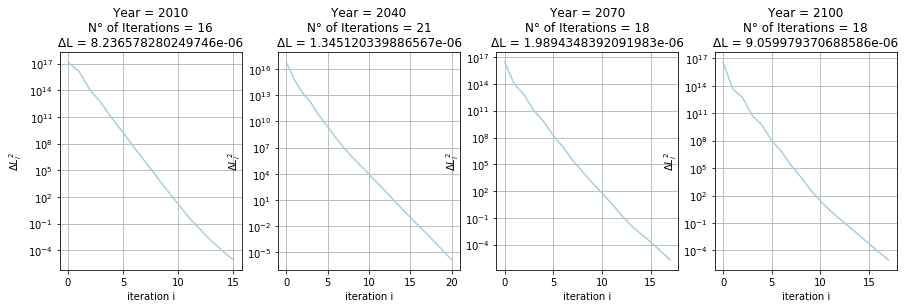

In [20]:
m1 = model(name='intermediate', tol=1e-5, scenario='intermediate')
m1.correct_south_south()
m1.calib_kappa()
m1.calib_A()
m1.calib_epsilon()
m1.calib_migcosts()
m1.fertility()
m1.simulate(report=True, report_from=0, max_iter=50)
m1.urbanization()

## Model 2: Minimalist scenario with south-south migration

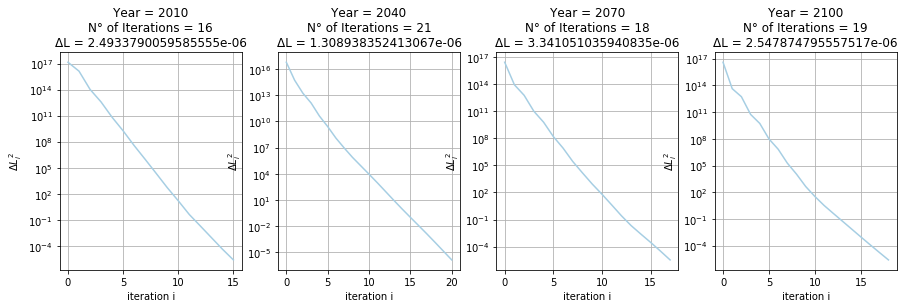

In [21]:
m2 = model(name='minimalist', tol=1e-5, scenario='minimalist')
m2.correct_south_south()
m2.calib_kappa()
m2.calib_A()
m2.calib_epsilon()
m2.calib_migcosts()
m2.fertility()
m2.simulate(report=True, report_from=0, max_iter=50)
m2.urbanization()

## Model 3: Maximalist scenario with south-south migration

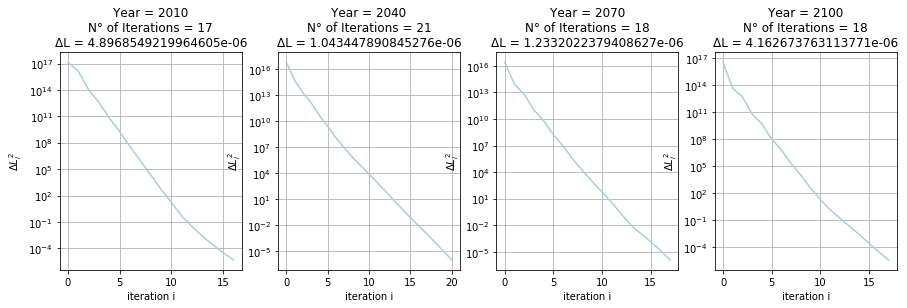

In [22]:
m3 = model(name='maximalist', tol=1e-5, scenario='maximalist')
m3.correct_south_south()
m3.calib_kappa()
m3.calib_A()
m3.calib_epsilon()
m3.calib_migcosts()
m3.fertility()
m3.simulate(report=True, report_from=0, max_iter=50)
m3.urbanization()

## Model 4: Intermediate scenario migration only to OECD

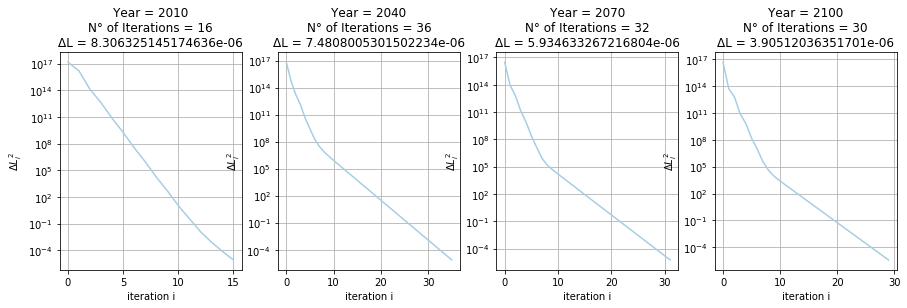

In [23]:
m4 = model(name='intermediate', tol=1e-5, scenario='intermediate',south_south_mig=False)
m4.correct_south_south()
m4.calib_kappa()
m4.calib_A()
m4.calib_epsilon()
m4.calib_migcosts()
m4.fertility()
m4.simulate(report=True, report_from=0, max_iter=50)
m4.urbanization()

In [24]:
m1.urbanization()
m2.urbanization()
m3.urbanization()
m4.urbanization()

# Run some checks

In [176]:
class check:
    def __init__(self,
                 name = "Michal's results",
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 B=0.5, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='new_checks.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        self.σ = σ 
        self.τ, self.μ, self.B  = τ, μ, B
        self.tol = tol
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')  
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        # irsbt = origin-destination-region-skill-time-specific
        data_irsbt = get_input(inputs, 'irsbt') 
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.A = data_irt['A'] # total factor productivity
        self.ω = data_irt['ω'] # 
        self.L = data_irst['L'] # resident population
        self.N = data_irst['N'] # native population
        self.w = data_irst['N'] # native population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        

check.MidxDataFrame = MidxDataFrame   
check.urbanization = urbanization

In [177]:
m0 = check()
m0.urbanization()

In [ ]:
mx = m4
for t in T[1:]:
    for r in R:
        for s in S:
            mx.native_split(r,s,t)            
    for r in R:
        for s in S:
            mx.resident_split(r,s,t)


In [178]:
def compare_models(model1, model2, var ='all', annotate_largest=10 ,size=15,fit_reg = False, cols=3):
    def plot_scatter(model1,model2,i):
        elem = model1.__dict__[i]
        if isinstance(elem, pd.DataFrame):
            tuples = set(list(model1.__dict__[i])).intersection(set(list(model2.__dict__[i])))
            tuples = sorted(list(tuples), key=lambda item: item[len(list(tuples)[0])-1])

            fig = plt.figure(figsize=(size, size)) 
            fig.subplots_adjust(hspace=.6, wspace=.6)
            count = 1
            for tup in tuples:
                
                y = model1.__dict__[i][tup]
                x = model2.__dict__[i][tup]
                fig.add_subplot(math.ceil(len(tuples)/cols), cols, count)
                count += 1
                sns.regplot(x, y, 
                            fit_reg = fit_reg,
                            scatter = True,
                            scatter_kws={'s': 25, 'alpha': 0.7}
                            )
                for c in model1.countries:
                    largest_diff = ((x/y-1)**2).nlargest(annotate_largest)
                    if c in list(largest_diff.index):
                        plt.annotate(model1.iso.loc[c], (x.loc[c], y.loc[c]))
                lims = [min(x.append(y)), max(x.append(y))]
                z = np.linspace(lims[0],lims[1])
                plt.plot(z,z,color='k')
                plt.xlim(lims)
                plt.ylim(lims)
                plt.xlabel(model2.name)
                plt.ylabel(model1.name)
                plt.xscale('log')
                plt.yscale('log')
                plt.title(i+' ['+str(tup)+']'+'\n'+'Correlation = '+str(round(x.corr(y),4)))
            plt.show()
            
    
    if var == 'all':
        for i in sorted(list(model1.__dict__)):
            print(i)
            plot_scatter(model1,model2,i)
                         
    else:
        plot_scatter(model1,model2,var)


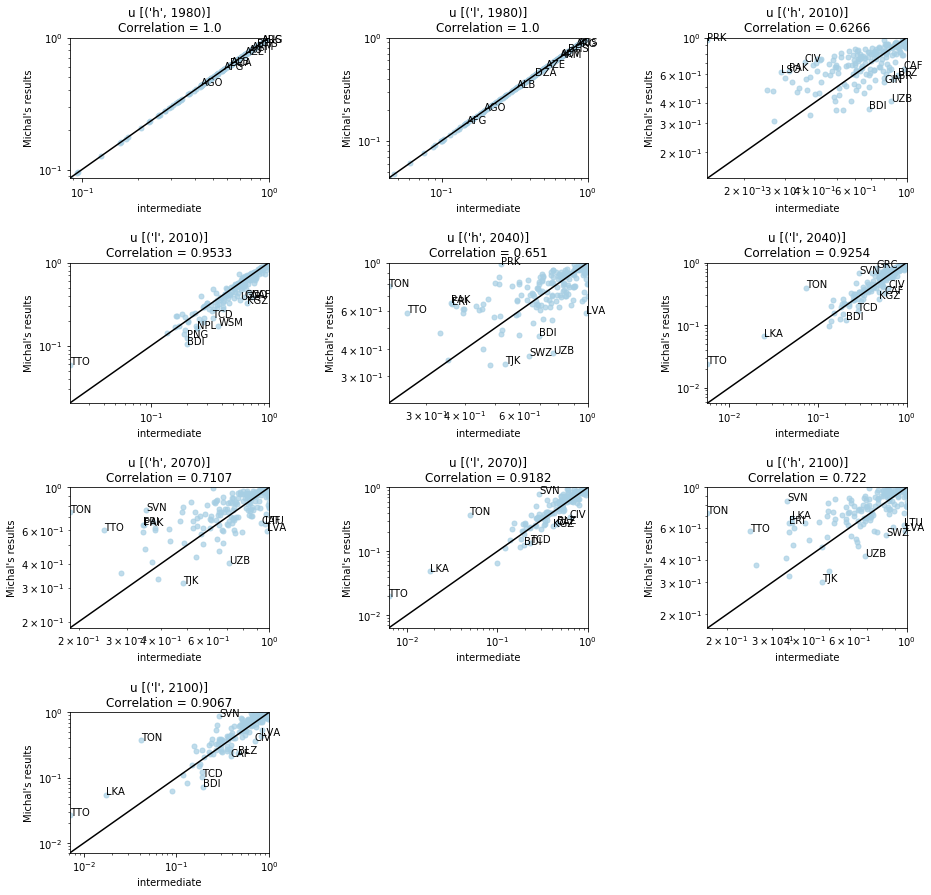

In [184]:
compare_models(m0,m1,'u')

# References

(<a id="cit-Burzynski2018" href="#call-Burzynski2018">Burzynski, Deuster <em>et al.</em>, 2018</a>) Burzynski Michal, Deuster Christoph, Docquier Frederic <em>et al.</em>, ``_Climate change, Inequality and Migration_'', Working paper, vol. , number , pp. , January 2018.  [online](https://perso.uclouvain.be/frederic.docquier/filePDF/BDDD_Nova2018.pdf)

